In [3]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import importlib
from sklearn.decomposition import PCA

path_src = os.path.abspath('../../../src')

# Agregar esa ruta al sys.path si no está ya
if path_src not in sys.path:
    sys.path.append(path_src)

# Importar utils normalmente
import utils
importlib.reload(utils)

# Importar funciones específicas
from utils import (
    kmeans_clustering_mlflow,
    transform_pca,
    silhouette_analysis,
    elbow_method,
    plot_davies_bouldin_scores,
    evaluar_calinski_harabasz
)


In [5]:
rfm_productos_local = pd.read_csv('../../../dataset/rfm_productos_local.csv')



print(rfm_productos_local.columns)

print("cantidad de columnas: ", len(rfm_productos_local.columns))

print("cantidad de filas: ", len(rfm_productos_local))


Index(['id_producto', 'recency', 'frequency', 'monetary', 'horario_promedio',
       '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12'],
      dtype='object')
cantidad de columnas:  18
cantidad de filas:  3638


In [7]:
rfm_productos_local.head()

,id_producto,recency,frequency,monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
0,10002,236,401,340.85,13,116.0,144.0,49.0,23.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10080,19,291,114.41,12,0.0,0.0,2.0,0.0,0.0,0.0,48.0,24.0,60.0,60.0,6.0,91.0,0.0
2,10120,6,182,38.22,13,16.0,0.0,30.0,28.0,0.0,3.0,0.0,5.0,35.0,10.0,10.0,39.0,6.0
3,10123C,254,5,3.25,12,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10124A,34,16,6.72,14,4.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [8]:
# Limpieza de outliers usando el método IQR para Recency, Frequency y Monetary
def remove_outliers_iqr(df, columns):
    """
    Elimina outliers usando el método IQR (Interquartile Range)
    """
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtramos los outliers
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# Columnas a limpiar
columns_to_clean = ['recency', 'frequency', 'monetary']

# Mostrar estadísticas antes de la limpieza
print("Estadísticas ANTES de la limpieza de outliers:")
print(rfm_productos_local[columns_to_clean].describe())
print(f"\nCantidad de registros antes: {len(rfm_productos_local)}")

# Aplicar limpieza de outliers
rfm_productos_local_clean = remove_outliers_iqr(rfm_productos_local, columns_to_clean)




Estadísticas ANTES de la limpieza de outliers:
           recency     frequency       monetary
count  3638.000000   3638.000000    3638.000000
mean     49.792194   1121.248488    1923.365069
std      90.096668   2576.397192    4864.170285
min       1.000000      1.000000       0.420000
25%       2.000000     58.000000     110.282500
50%       5.000000    316.000000     505.955000
75%      37.000000   1121.000000    1707.675000
max     374.000000  49086.000000  110713.000000

Cantidad de registros antes: 3638


In [9]:
id_producto= rfm_productos_local_clean['id_producto'].copy()

id_producto.head()

1     10080
2     10120
4    10124A
5    10124G
6     10125
Name: id_producto, dtype: object

In [10]:
rfm_productos_local_clean.drop(columns=['id_producto'], inplace=True)

In [12]:
rfm_productos_local_clean

,recency,frequency,monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
1,19,291,114.41,12,0.0,0.0,2.0,0.0,0.0,0.0,48.0,24.0,60.0,60.0,6.0,91.0,0.0
2,6,182,38.22,13,16.0,0.0,30.0,28.0,0.0,3.0,0.0,5.0,35.0,10.0,10.0,39.0,6.0
4,34,16,6.72,14,4.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
5,34,17,7.14,15,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0
6,6,615,436.75,12,143.0,100.0,0.0,72.0,62.0,7.0,13.0,75.0,65.0,40.0,30.0,2.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3633,5,12,3.48,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
3634,5,14,5.98,15,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.0
3635,5,12,3.48,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
3636,4,61,18.65,15,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0


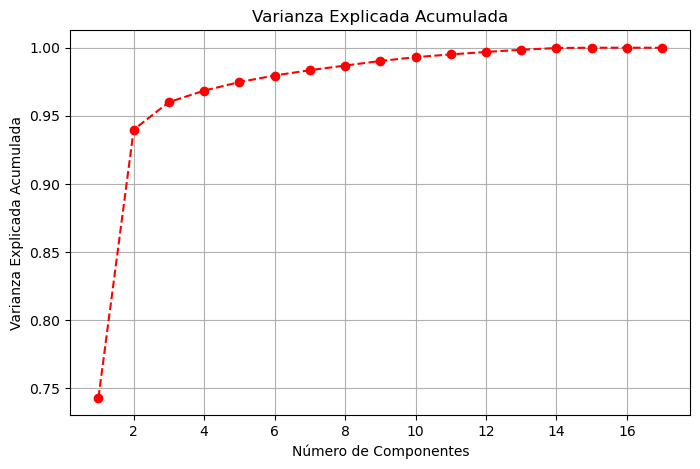

In [14]:
pca=PCA()

pca.fit(rfm_productos_local_clean)

var_exp=pca.explained_variance_ratio_

# Graficar varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp)+1), var_exp.cumsum(), marker='o', linestyle='--', color='red')
plt.ylabel('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.title('Varianza Explicada Acumulada')
plt.grid()
plt.show()


podemos observar que con dos componentes tenemos una varianza acumualda de casi el 94% lo cual esta bastante bienpor alata dimensionalidad que posse el mismo, asi que a qui la decisionq ue tomamos es trabajar con dos componentes

In [16]:
# Calcular las componentes principales (2 componentes)
componentes = transform_pca(rfm_productos_local_clean, 2)

# dichas compoenentes la transformamos en un dataframe de pandas , con los mismos indices que el dataframe original , para hacer un analisis psoteriormente de los grupos que forma k-means
dataframe_pca = pd.DataFrame(componentes, columns=['PC1', 'PC2'],index=rfm_productos_local_clean.index)

dataframe_pca.head()


,PC1,PC2
1,-0.211307,0.017647
2,-0.219449,-0.131063
4,-0.367540,0.150997
5,-0.372071,0.152744
6,-0.035202,-0.067008


Para n_clusters = 2, el silhouette promedio es: 0.5350
Para n_clusters = 3, el silhouette promedio es: 0.5374
Para n_clusters = 4, el silhouette promedio es: 0.4787
Para n_clusters = 5, el silhouette promedio es: 0.4460
Para n_clusters = 6, el silhouette promedio es: 0.4612
Para n_clusters = 7, el silhouette promedio es: 0.4701
Para n_clusters = 8, el silhouette promedio es: 0.4507
Para n_clusters = 9, el silhouette promedio es: 0.4264
Para n_clusters = 10, el silhouette promedio es: 0.4311
Para n_clusters = 11, el silhouette promedio es: 0.4003
Para n_clusters = 12, el silhouette promedio es: 0.4137
Para n_clusters = 13, el silhouette promedio es: 0.4078
Para n_clusters = 14, el silhouette promedio es: 0.4101


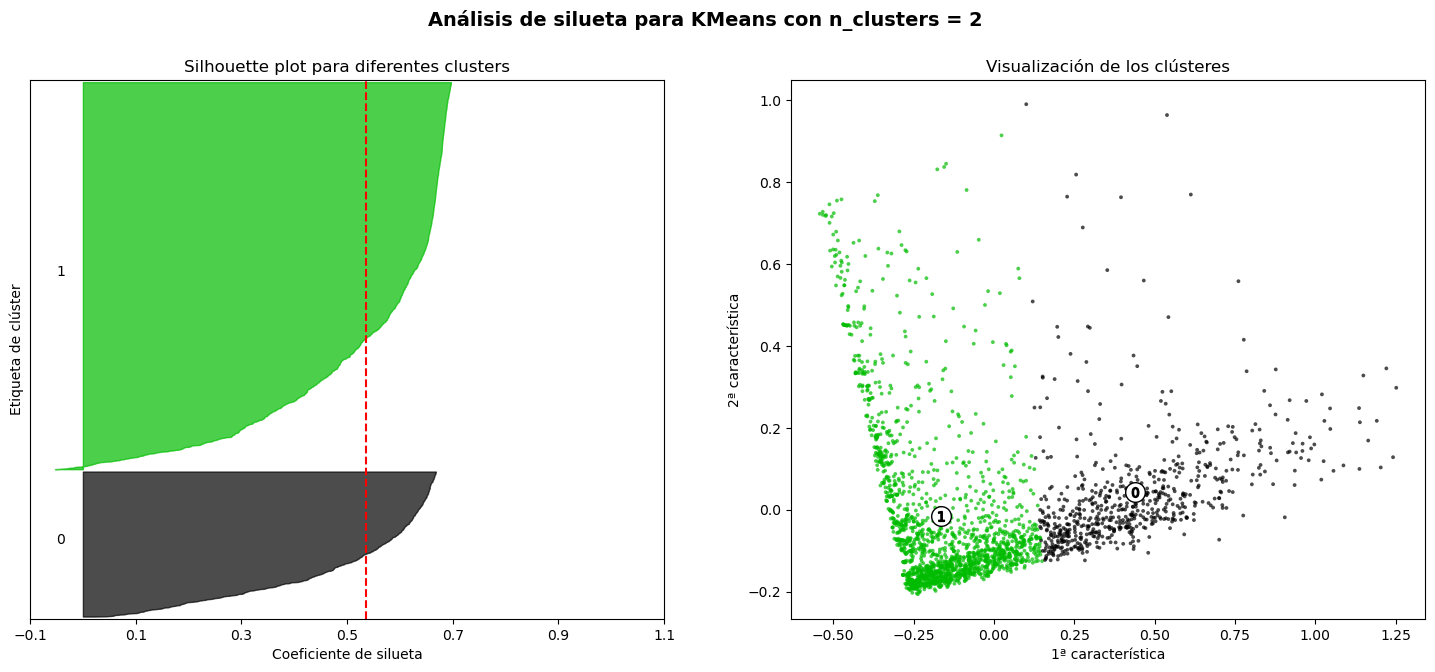

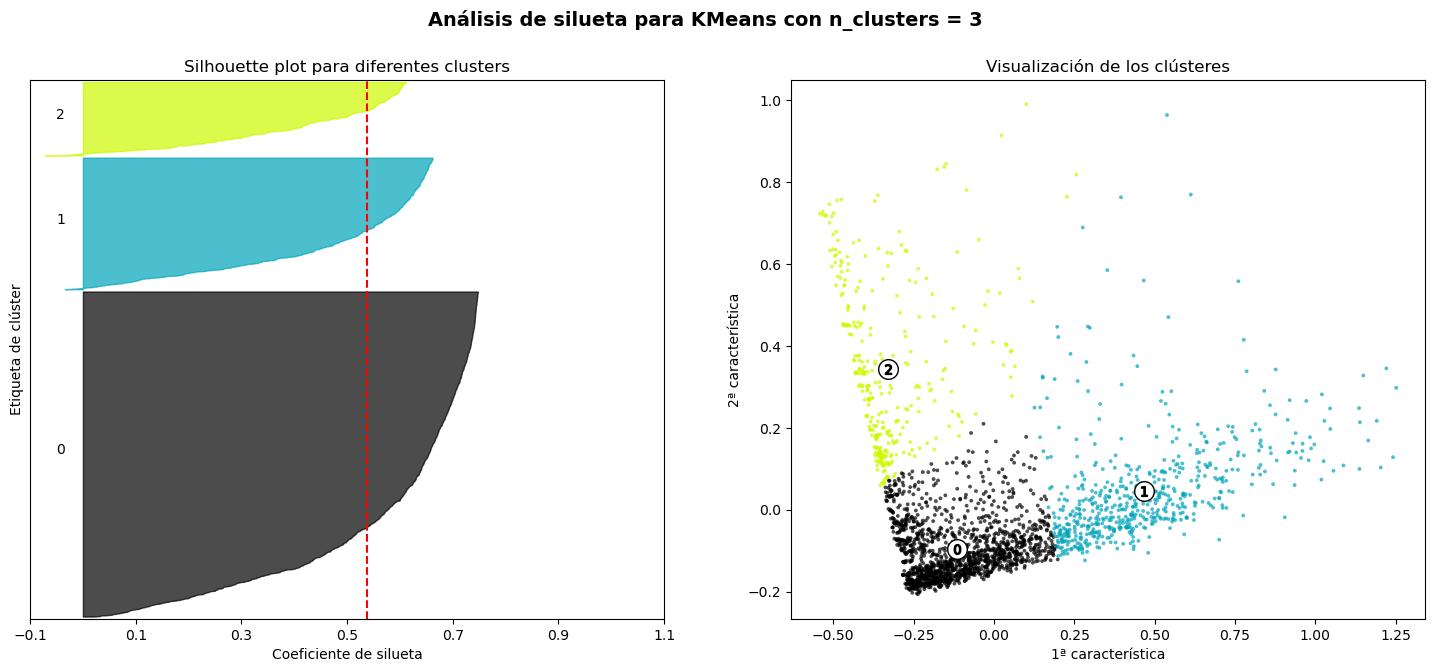

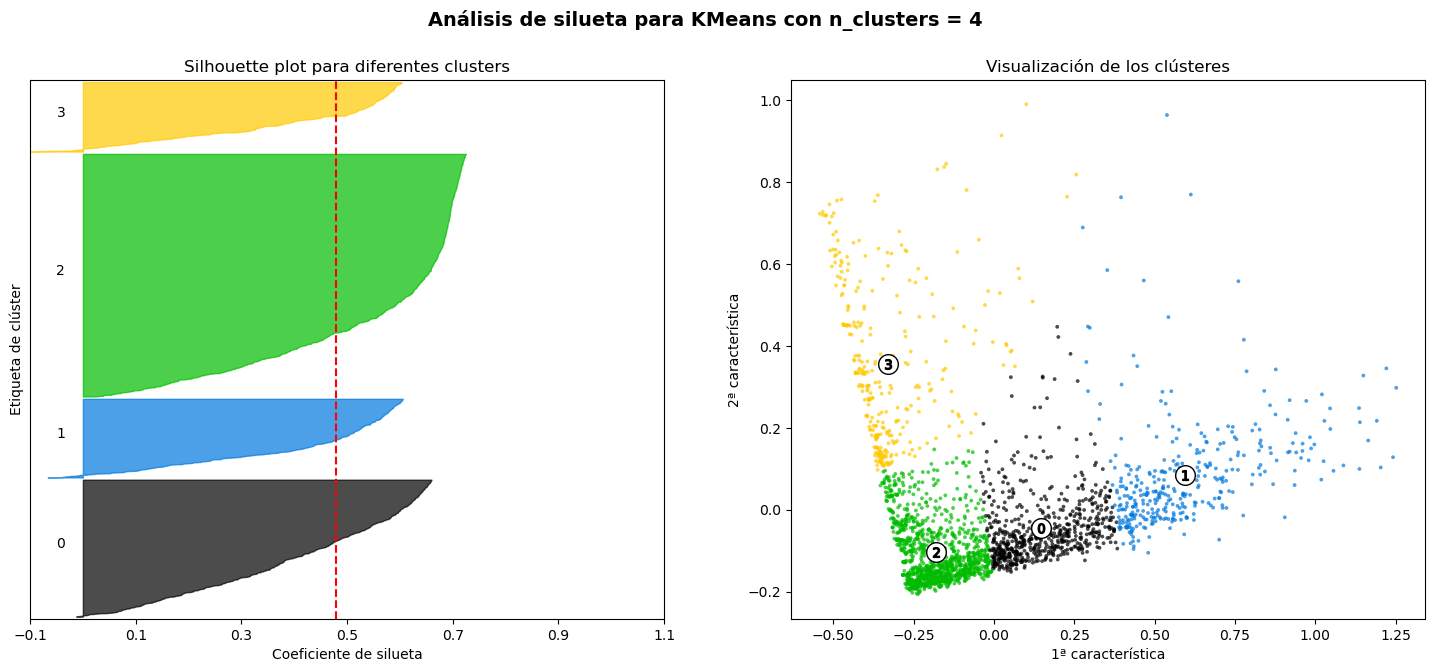

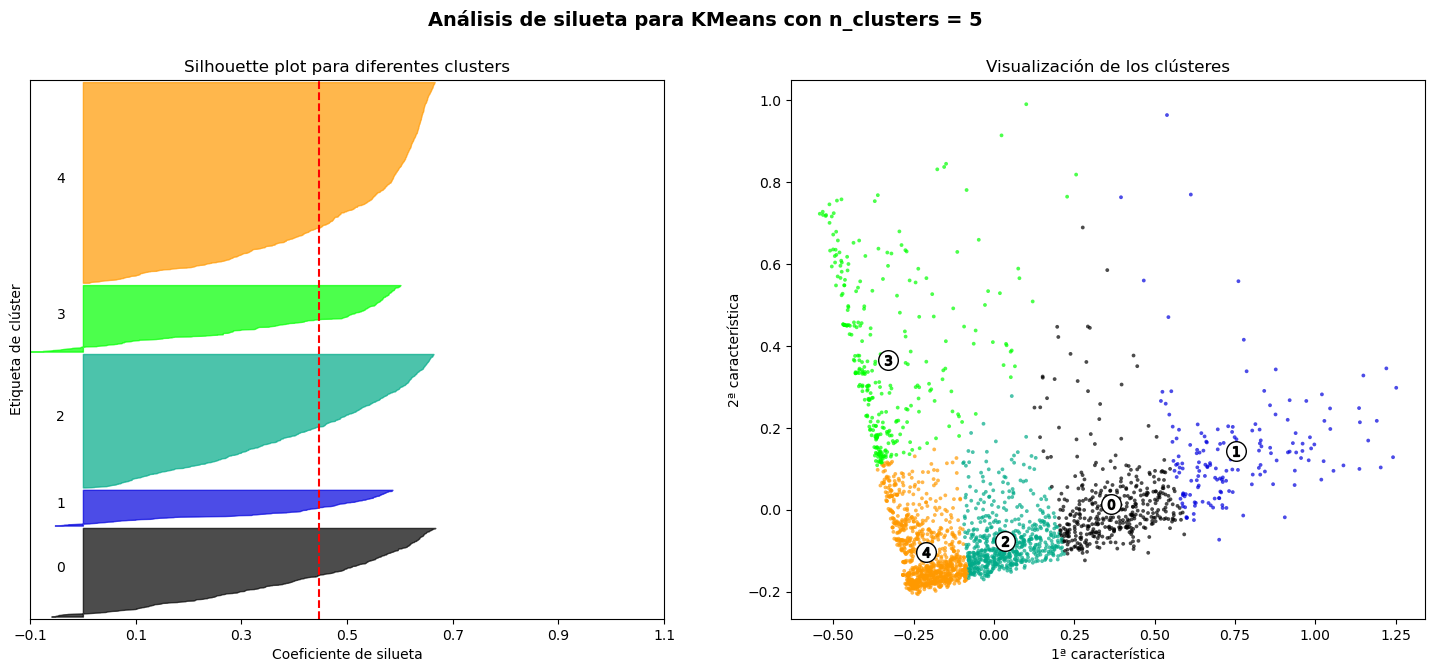

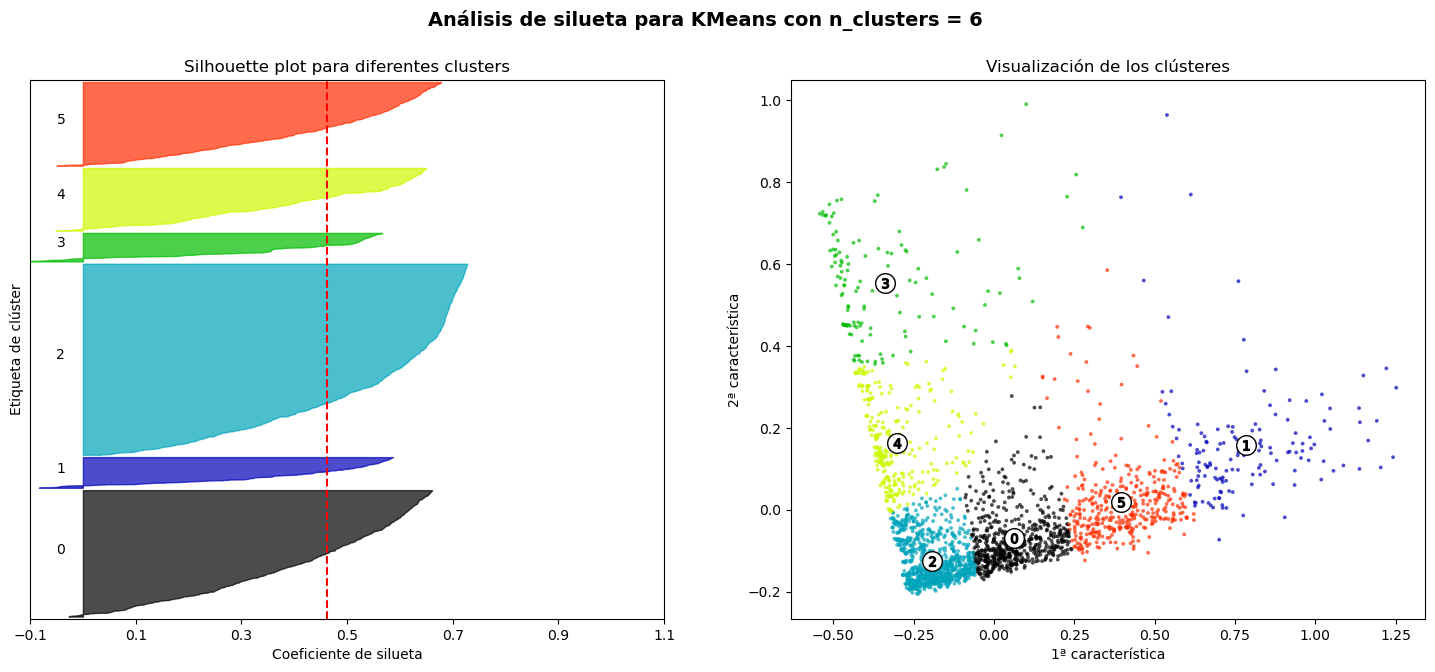

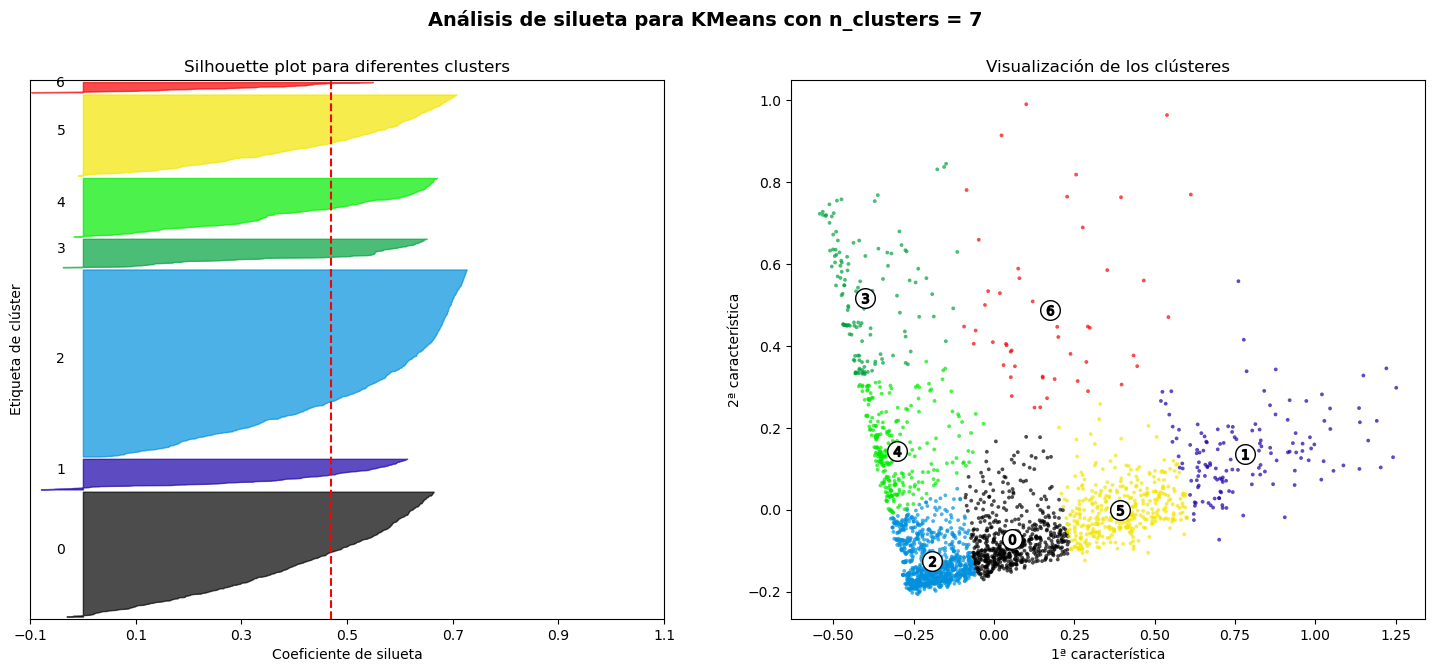

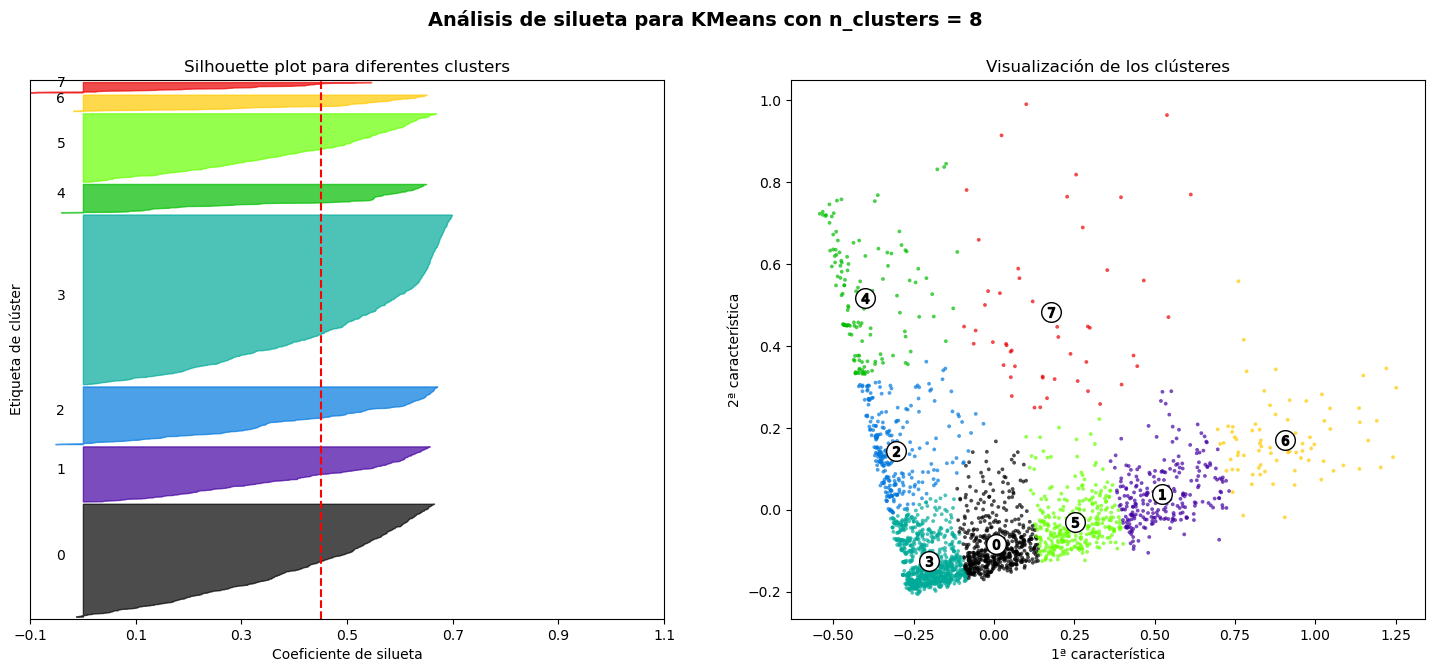

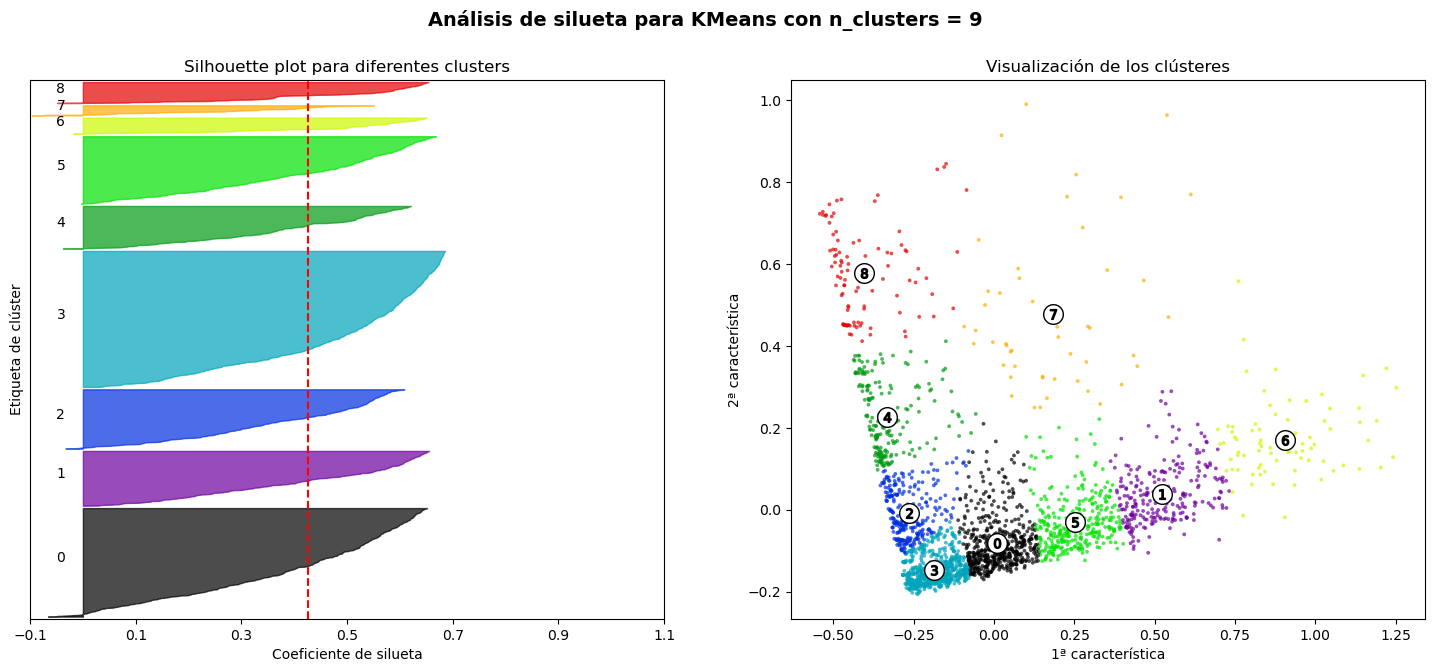

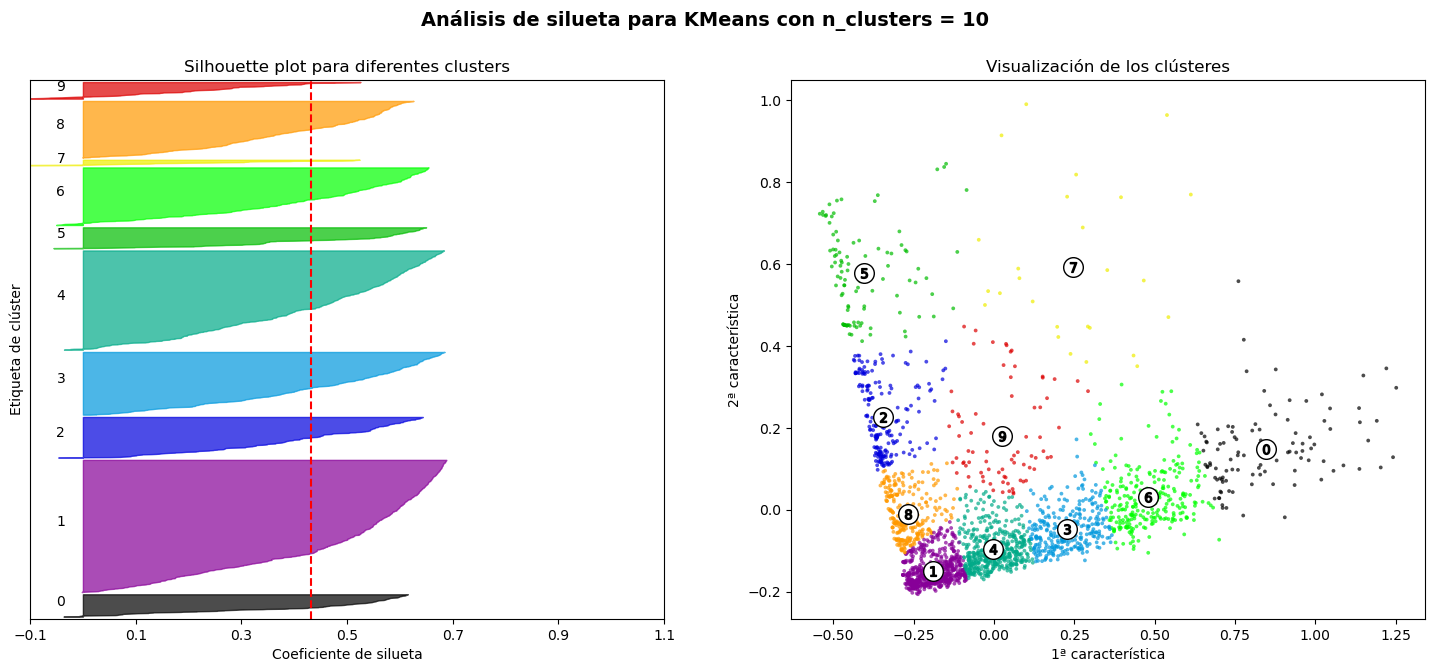

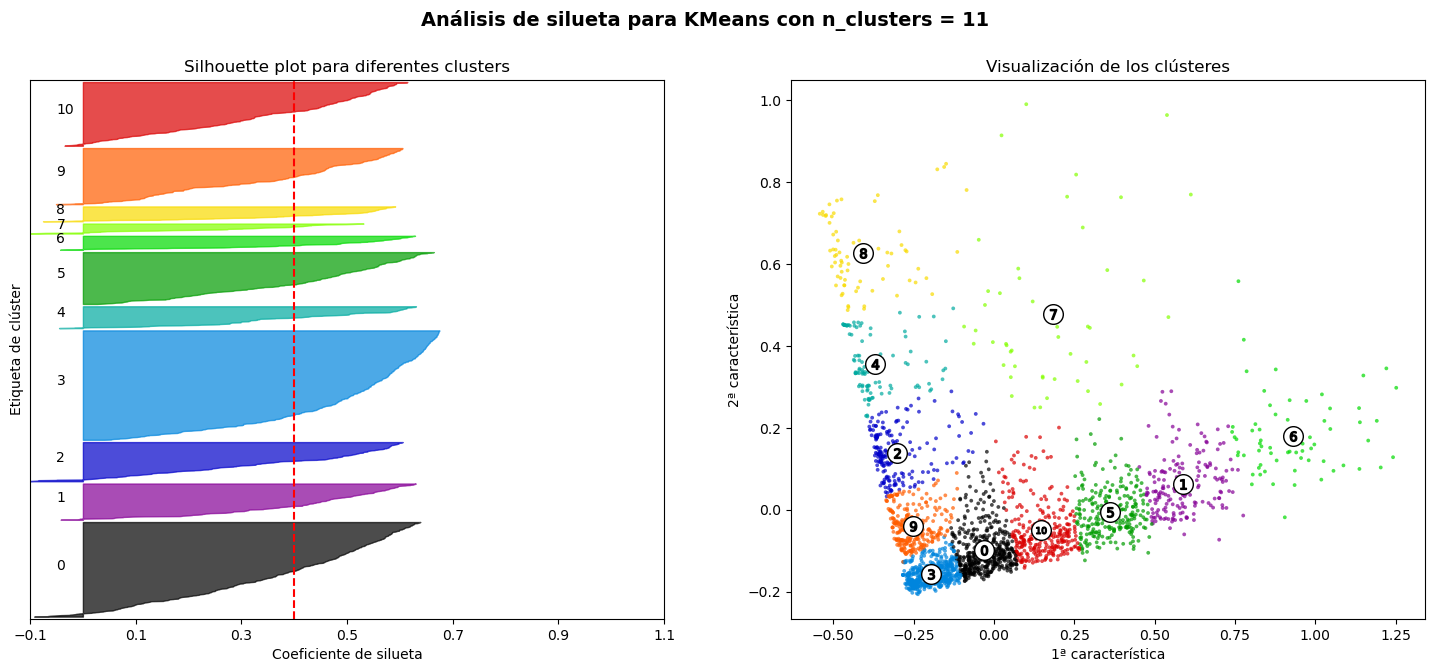

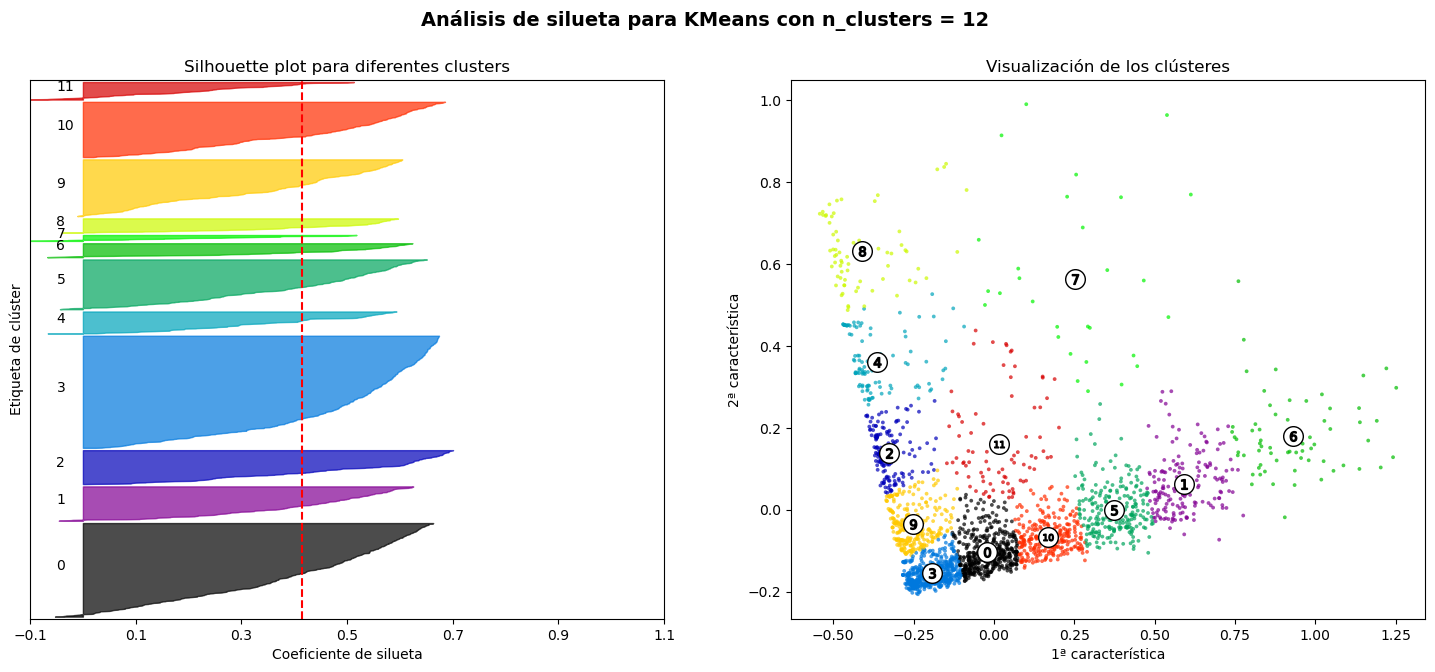

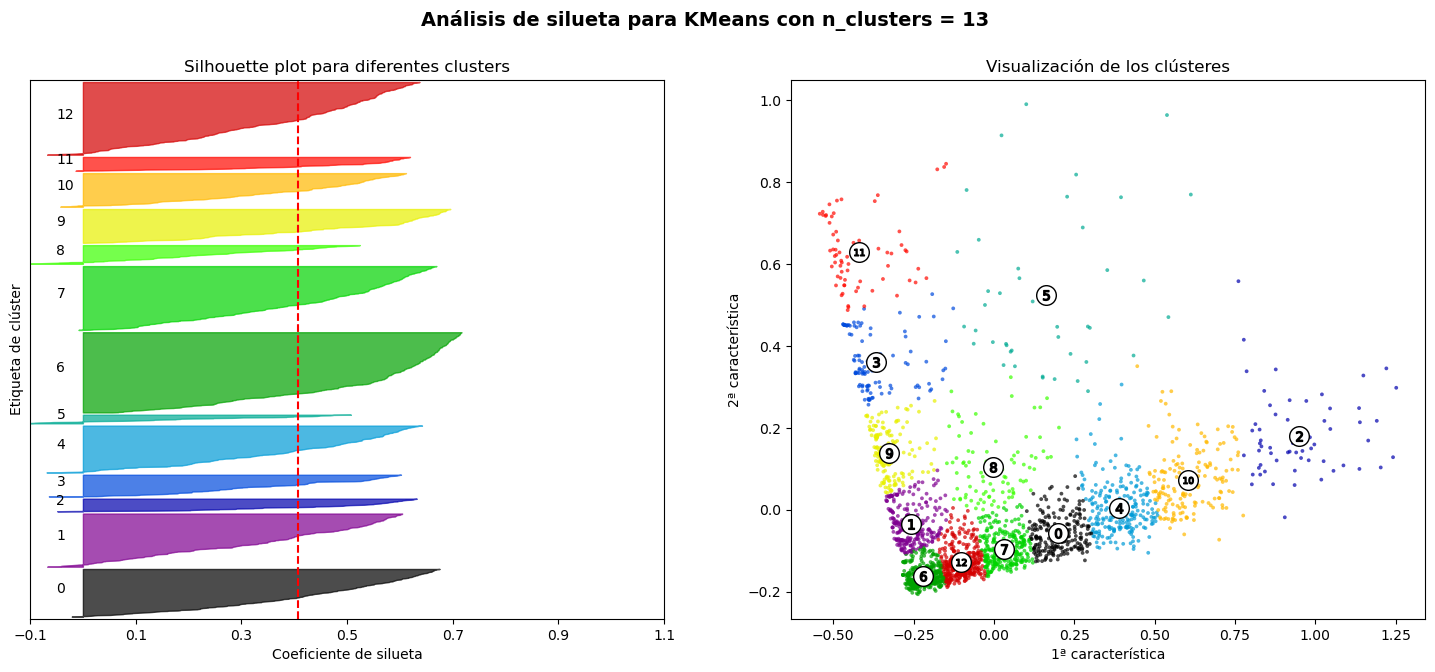

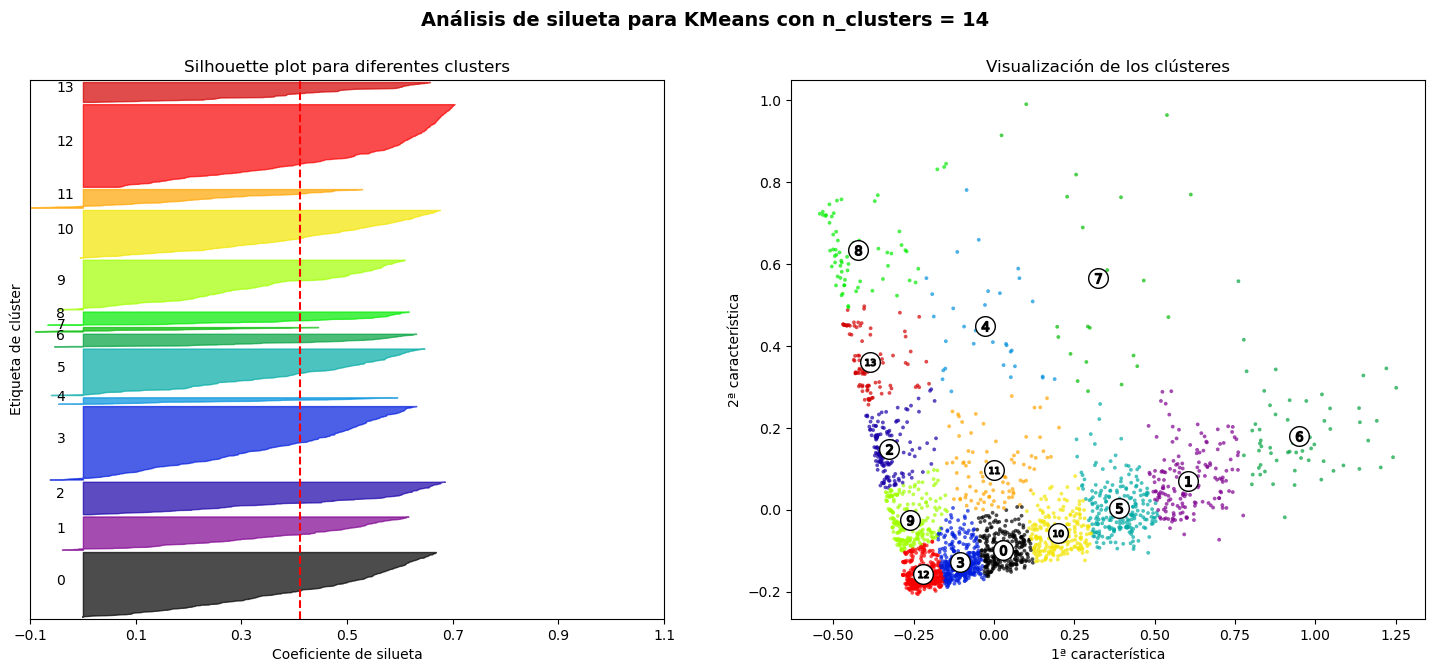

In [17]:
average_silhouette=silhouette_analysis(dataframe_pca.values, range(2, 15))

average_cluster=pd.DataFrame({'n_clusters':range(2,15),'average_silhouette':average_silhouette})



Observaciones 

- El mayor valor es con k = 3 → es el mejor desde el punto de vista de separación y cohesión de clústeres.

- A partir de k = 4 en adelante, los valores disminuyen progresivamente → los clústeres empiezan a solaparse o a dividirse sin necesidad.

- Con k = 2 el valor también es alto, pero menor que con k = 3.

el ganador es el numero cluster igual 3<>

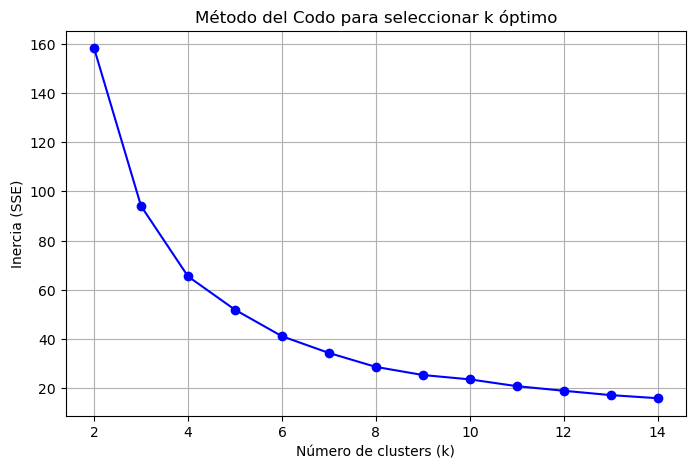

In [18]:
inertias=elbow_method(dataframe_pca.values, range(2, 15))

El "codo" más visible está en k = 3. Después de ese punto, aunque la inercia sigue bajando, la mejora no justifica la complejidad adicional de añadir más clústeres. Este resultado coincide con el análisis del coeficiente de silueta, donde también k = 3 tuvo el valor más alto.


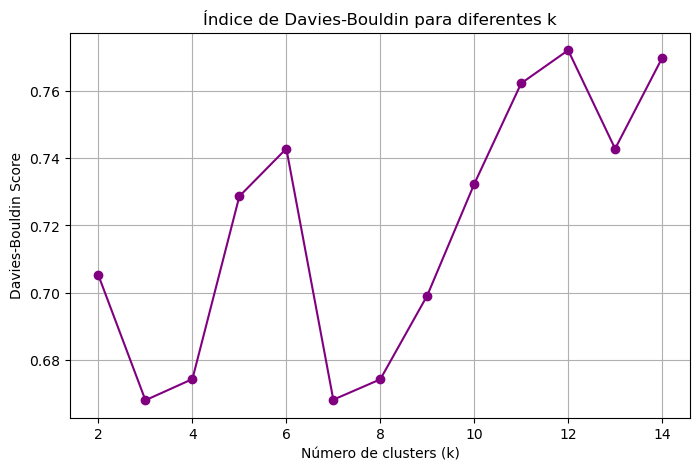

{2: np.float64(0.7051287431225081), 3: np.float64(0.6680501688354207), 4: np.float64(0.6743291027580526), 5: np.float64(0.7286520922088123), 6: np.float64(0.7428176085911619), 7: np.float64(0.6682035377964708), 8: np.float64(0.674256049498007), 9: np.float64(0.6991677961826732), 10: np.float64(0.7322964420989535), 11: np.float64(0.7622304964444955), 12: np.float64(0.7720610164649959), 13: np.float64(0.7427880559748524), 14: np.float64(0.769752523147641)}


In [19]:
db_scores=plot_davies_bouldin_scores(dataframe_pca.values, range(2, 15))

print(db_scores)

sigue ganando k=3

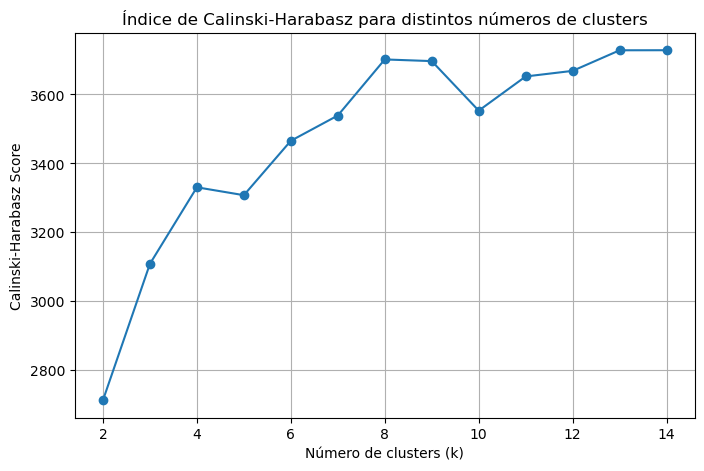

[np.float64(2713.105652068806), np.float64(3108.7035733761695), np.float64(3330.7396991741416), np.float64(3307.8392690564483), np.float64(3465.616679046202), np.float64(3538.949106633965), np.float64(3701.6182189103442), np.float64(3696.7917208897543), np.float64(3553.0740896768075), np.float64(3652.251786276217), np.float64(3668.4891336192086), np.float64(3728.1677177638953), np.float64(3728.350727888772)]


In [20]:
ch_scores=evaluar_calinski_harabasz(dataframe_pca.values, range(2, 15))

print(ch_scores)

Run ID final clustering: 512f1acfebc9467b9a11e582bb04fe76
🏃 View run Final_Clustering_k=3 at: http://localhost:5000/#/experiments/768932697419387509/runs/512f1acfebc9467b9a11e582bb04fe76
🧪 View experiment at: http://localhost:5000/#/experiments/768932697419387509


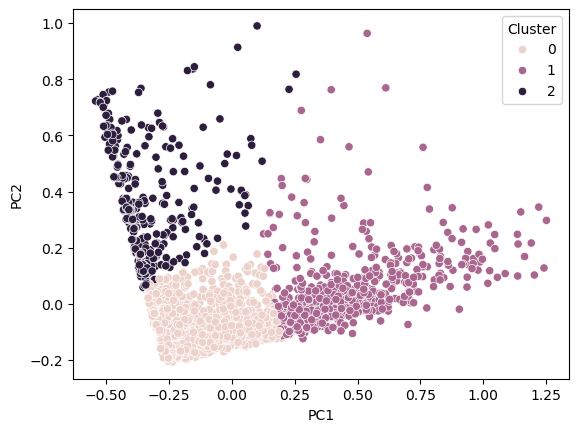

In [21]:
data_pca_cluster=kmeans_clustering_mlflow(dataframe_pca, ['PC1', 'PC2'],10,3,'KMEANS_PRODUCTO_LOCAL')

sns.scatterplot(data=data_pca_cluster,x='PC1',y='PC2',hue='Cluster')
plt.show()

In [22]:
data_pca_cluster

,PC1,PC2,Cluster
1,-0.211307,0.017647,0
2,-0.219449,-0.131063,0
4,-0.367540,0.150997,2
5,-0.372071,0.152744,2
6,-0.035202,-0.067008,0
...,...,...,...
3633,-0.282774,-0.159277,0
3634,-0.281942,-0.159039,0
3635,-0.282774,-0.159277,0
3636,-0.264165,-0.168434,0


In [23]:
id_producto.index = data_pca_cluster.index

In [24]:
data_pca_cluster['id_producto'] = id_producto

In [25]:
data_pca_cluster = data_pca_cluster[['id_producto', 'PC1', 'PC2', 'Cluster']]

In [26]:
data_pca_cluster

,id_producto,PC1,PC2,Cluster
1,10080,-0.211307,0.017647,0
2,10120,-0.219449,-0.131063,0
4,10124A,-0.367540,0.150997,2
5,10124G,-0.372071,0.152744,2
6,10125,-0.035202,-0.067008,0
...,...,...,...,...
3633,90214U,-0.282774,-0.159277,0
3634,90214V,-0.281942,-0.159039,0
3635,90214W,-0.282774,-0.159277,0
3636,90214Y,-0.264165,-0.168434,0


In [27]:
rfm_productos_local_clean['Cluster']=data_pca_cluster['Cluster']
rfm_productos_local_clean['id_producto']=id_producto


In [29]:
rfm_productos_local_clean.head()

,recency,frequency,monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,Cluster,id_producto
1,19,291,114.41,12,0.0,0.0,2.0,0.0,0.0,0.0,48.0,24.0,60.0,60.0,6.0,91.0,0.0,0,10080
2,6,182,38.22,13,16.0,0.0,30.0,28.0,0.0,3.0,0.0,5.0,35.0,10.0,10.0,39.0,6.0,0,10120
4,34,16,6.72,14,4.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2,10124A
5,34,17,7.14,15,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,2,10124G
6,6,615,436.75,12,143.0,100.0,0.0,72.0,62.0,7.0,13.0,75.0,65.0,40.0,30.0,2.0,6.0,0,10125


In [31]:
rfm_productos_local_clean.columns

Index(['recency', 'frequency', 'monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'Cluster', 'id_producto'],
      dtype='object')

In [32]:
cluster_summary = rfm_productos_local_clean.groupby('Cluster').mean(numeric_only=True)
display(cluster_summary)

,recency,frequency,monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
Cluster,,,,,,,,,,,,,,,,,
0,7.040296,307.029550,496.349577,13.029550,22.933512,20.644056,15.570181,20.243788,15.514439,16.355272,17.972465,20.035594,20.912021,31.474815,37.489590,46.678979,21.204835
1,5.097844,1491.779436,1880.921758,12.930348,75.796020,57.938640,67.890547,82.542289,86.285240,95.686567,96.064677,104.658375,112.452736,187.535655,207.618574,242.835821,74.474295
2,49.693452,167.824405,264.116369,13.205357,14.845238,11.148810,9.080357,13.547619,13.985119,12.937500,18.416667,15.696429,12.360119,21.053571,21.943452,2.809524,0.000000


In [33]:
cluster_summary.columns

Index(['recency', 'frequency', 'monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12'],
      dtype='object')

# cantidad mensuales promedios en los periodos

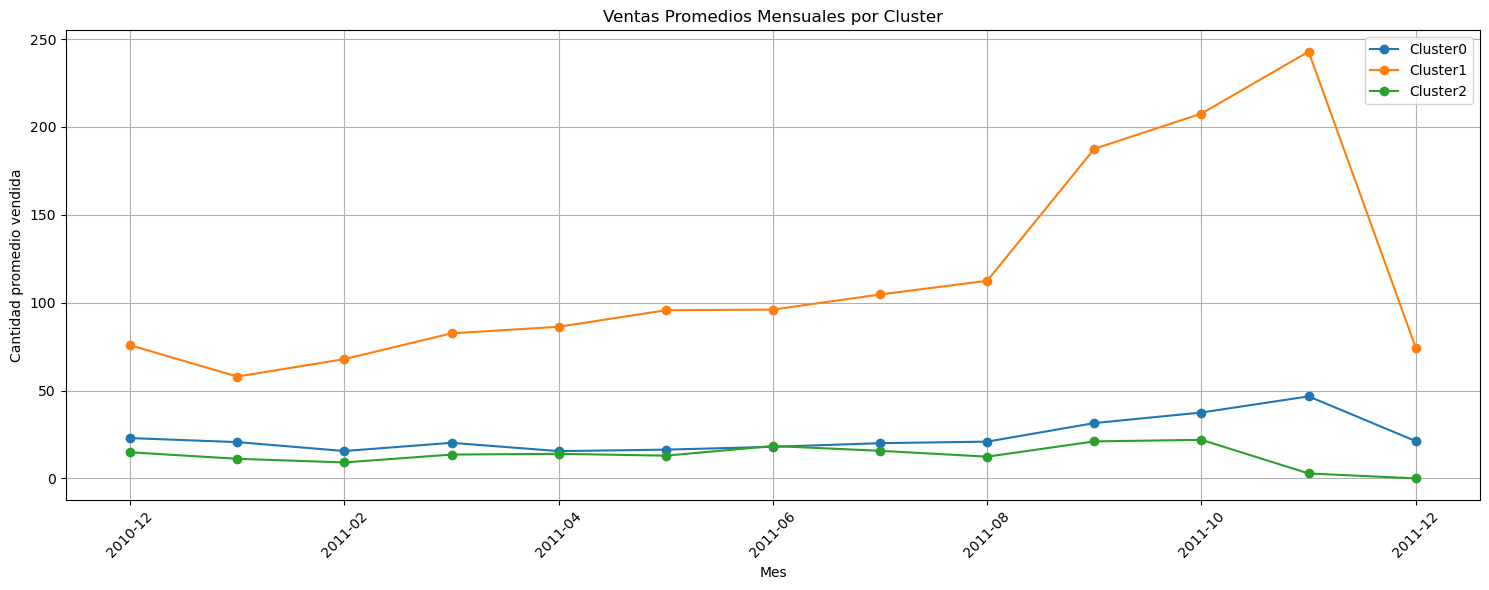

In [34]:
cluster0_mes= cluster_summary.iloc[0].T
cluster1_mes= cluster_summary.iloc[1].T
cluster2_mes= cluster_summary.iloc[2].T

columnas_fechas = [col for col in rfm_productos_local_clean.columns if col.startswith('201')]

cluster0_mes=cluster0_mes[columnas_fechas]
cluster1_mes=cluster1_mes[columnas_fechas]
cluster2_mes=cluster2_mes[columnas_fechas]

ventas_promedios_mensuales=pd.concat([cluster0_mes,cluster1_mes,cluster2_mes],axis=1)
ventas_promedios_mensuales.columns=['Cluster0','Cluster1','Cluster2']

ventas_promedios_mensuales.plot(
    figsize=(15, 6),
    title='Ventas Promedios Mensuales por Cluster',
    marker='o' ,
    markersize=6 )

plt.xlabel("Mes")
plt.ylabel("Cantidad promedio vendida")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# RFM

In [35]:
rfm_columnas=['recency', 'frequency', 'monetary']
cluster0_rfm=cluster_summary.iloc[0].T
cluster1_rfm=cluster_summary.iloc[1].T
cluster2_rfm=cluster_summary.iloc[2].T

cluster0_rfm=cluster0_rfm[rfm_columnas]
cluster1_rfm=cluster1_rfm[rfm_columnas]
cluster2_rfm=cluster2_rfm[rfm_columnas]

rfm_promedio_cluster=pd.concat([cluster0_rfm,cluster1_rfm,cluster2_rfm],axis=1)
rfm_promedio_cluster.columns=['Cluster 0','Cluster 1','Cluster 2']


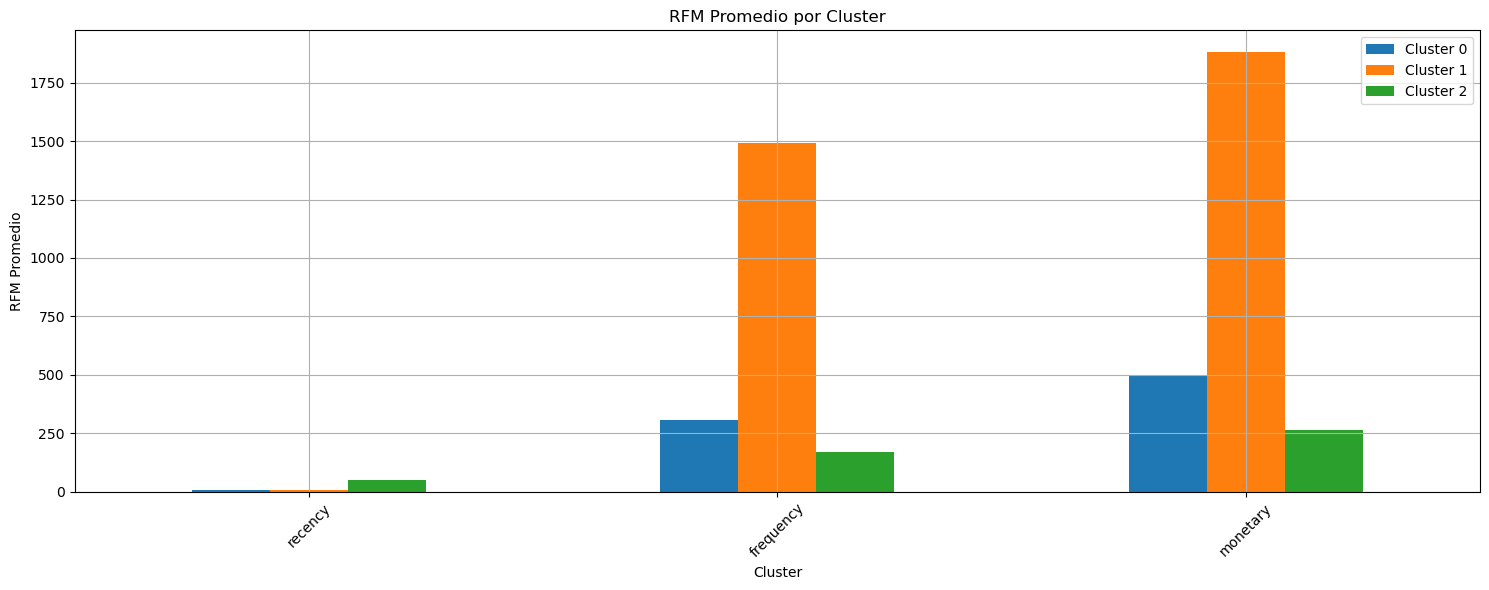

In [36]:
rfm_promedio_cluster.plot(kind='bar', figsize=(15, 6))
plt.title('RFM Promedio por Cluster')
plt.xlabel('Cluster')
plt.ylabel('RFM Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()